# Assess Masking

The goal of this notebook is to load in beh, spk and masking data to assess how much masking (0ing out of ephys data) is occuring on a per trial basis across a variety of sessions.

In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import os
from utils import *

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

In [2]:
def spks_dict_extract(spks_dict):
    """Function to help extract useful info from spks_dict that is nested deeply
    
    inputs
    ------
    spks_dict : dict, with spk info from .mat file
    
    returns
    -------
    spk2fsm    : arr, slope and y-int for getting from spike time to beh time
    trode_nums : list, what tetrode each cell is on in the session (1-32)
    fs         : int, sample rate of ephys
    """
    spk2fsm = spks_dict['behav_session'][0]['spk2fsm_rt'][0][0][0] #[m, b]
    
    trode_nums = []
    for i in range(len(spks_dict['trodenum'])):
        trode_nums.append(spks_dict['trodenum'][i][0][0])
        
    fs = spks_dict['fs'][0][0][0]
    
    return spk2fsm, trode_nums, fs

In [28]:
def load_masks(trode_nums, sess_dir):
    """Function for loading mask info stores in sortedd session direactory 
    based on the active tetrodes in the session
    
    inputs
    ------
    trode_num : list, what tetrode each cell is on in the session (1-32)
    sess_dir : path to directory for a sorted session with mask NPY files for each bundle
    
    returns
    -------
    mask_info : list, first item the list is unique trodes num list that is N long, remaining 
                N list items are masks for each unique tetrode (this needs to be modified for
                having multiple cells on the same bndl)
    """
    
    # intialize space
    
    mask_info = []
    
    # deal with multiple cells on one tetrode
    unique_trodes = np.unique(trode_nums)
    mask_info.append(unique_trodes)
    
    for trode in unique_trodes:
        
        # determine (unefficiently) which mask file is correct
        if trode <= 8:
            bndl = "bundle1_mask_info"
        elif trode > 8 <= 16:
            bndl = "bundle2_mask_info"
        elif trode > 16 <= 24:
            bndl = "bundle3_mask_info"
        elif trode > 24 <= 32:
            bndl = "bundle4_mask_info"
        else:
            print("trode not between 1-32, function will break")
            
        # load it, flatten & convert to bool (0.0 = noise, 1.0 = signal)
        bndl_mask = np.load(os.path.join(sess_dir, bndl))
        bndl_mask = bndl_mask.flatten()
        bndl_mask_bool = np.where(bndl_mask == 0.0, True, False) 
        mask_info.append(bndl_mask_bool)
        
    return mask_info

In [50]:
def mask2fsm(mask_info, fs, spk2fsm):
    
    """Quick function to use shape of boolean mask to create a second array in fsm time
    to allow for a common timeframe between task events and ephys masking"""
    
    # create a array the same length of the bool with values in seconds at fs
    mask_sec = np.linspace(0, len(mask_info[1])/fs, len(mask_info[1]))
    
    # convert the time array above from spk time to fsm time
    mask_fsm = (mask_sec * spk2fsm[0]) + spk2fsm[1]
    
    return mask_fsm

## I/O

In [24]:
t_b = os.path.join(dir_name, sess_name, 'beh_df.csv')
os.path.exists(t_b)

overwrite = True

if os.path.exists(t_b) and overwrite == False:
    print('ya')

In [71]:
# global
sess_name = 'W122_08_31_2019_1_fromSD' # this will be flexible
dir_name  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'
sess_dir = os.path.join(dir_name, sess_name)

# create paths
beh_path  = os.path.join(dir_name, sess_name, beh_mat)
spks_path = os.path.join(dir_name, sess_name, spks_mat)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)
spk2fsm, trode_nums, fs = spks_dict_extract(spks_dict)
mask_info = load_masks(trode_nums, sess_dir)
mask_beh_s = mask2fsm(mask_info, fs, spk2fsm)

In [72]:
no_viol_df = beh_df[beh_df['hit_hist'] != 'viol']
# save trial number, but reset the index
no_viol_df['trial_num'] = no_viol_df.index 
no_viol_df.index = range(len(no_viol_df))

c:\users\brodylab\anaconda3\envs\pwmephys\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
len(mask_info)

3

In [77]:
start = no_viol_df['c_poke']
end = no_viol_df['aud2_off']


cut_samples = []
trial_len = []
trial = []
trode = 2
# for trode in range(1, len(mask_info)-1):
#     print(trode)
for trial in range(len(start)):

    idx_s = np.searchsorted(mask_beh_s, start[trial], side = "left")
    idx_e = np.searchsorted(mask_beh_s, end[trial], side = "left")

    trial_len.append(idx_e - idx_s)
    cut_samples.append(np.sum(mask_info[trode][idx_s:idx_e]))


In [82]:
len(mask_info[2]), idx_s

(160930860, 160930860)

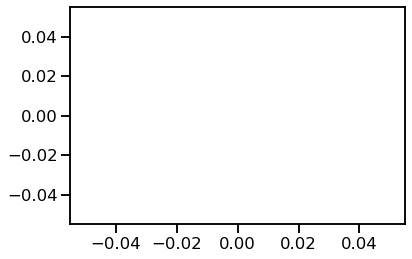

In [78]:
plt.plot(mask_info[2][idx_s:idx_e])

(array([103., 113.,  61.,  30.,  15.,   7.,   3.,   2.,   1.,   1.]),
 array([    0. ,  7346.8, 14693.6, 22040.4, 29387.2, 36734. , 44080.8,
        51427.6, 58774.4, 66121.2, 73468. ]),
 <BarContainer object of 10 artists>)

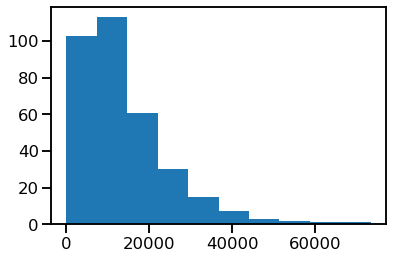

In [83]:
plt.hist(cut_samples)

In [70]:
counter = 0
n_samples = 10000
for i in range(len(cut_samples)):
    if cut_samples[i] < n_samples:
        counter+=1
print(counter)

23
